# Project Setup & Installing Dependencies

In [ ]:
!pip install pandas transformers torch scikit-learn nltk wordcloud

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import json
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer,BertModel
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/hospital_sentiment_project/medical_review_data.csv')

In [ ]:
df.head()

,Feedback,Aspect,Sentiment
0,Good and clean hospital. There is great team o...,"staff, cleanliness, treatment",1
1,Had a really bad experience during discharge. ...,staff,0
2,I have visited to take my second dose and Proc...,"staff, treatment",1
3,That person was slightly clueless and offered ...,general,1
4,There is great team of doctors and good OT fac...,"staff, treatment",1


In [ ]:
df.shape

(6596, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6596 entries, 0 to 6595
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Feedback   6596 non-null   object
 1   Aspect     6596 non-null   object
 2   Sentiment  6596 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 154.7+ KB


In [ ]:
# checking missing values
df.isnull().sum()

,0
Feedback,0
Aspect,0
Sentiment,0


In [ ]:
# dropping duplicates
df.drop_duplicates(inplace=True)

# Preprocesing and Visualization

In [ ]:
# clean the feedback column removing special char like (#!:)

def clean_feedback(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s\'-]', '', text)
    return text.strip()

df['cleaned_feedback'] = df['Feedback'].apply(clean_feedback)

In [ ]:
# split comma-separated aspects
df['Aspect'] = df['Aspect'].str.split(',')
df = df.explode('Aspect').reset_index(drop=True)
df['Aspect'] = df['Aspect'].str.strip()

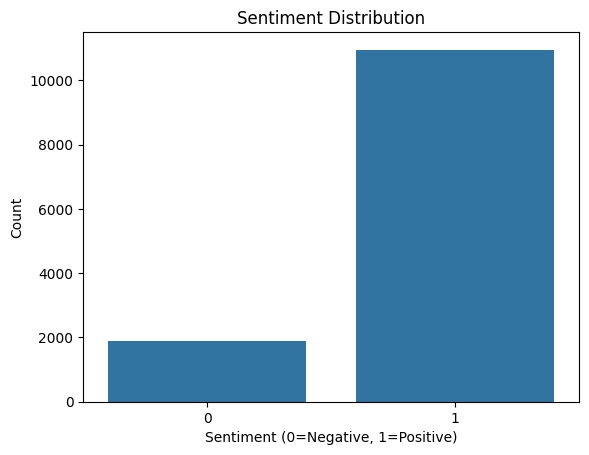

In [ ]:
# plot sentiment distribution
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.show()

/tmp/ipython-input-13-1731597169.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Aspect', data=df, palette='deep')


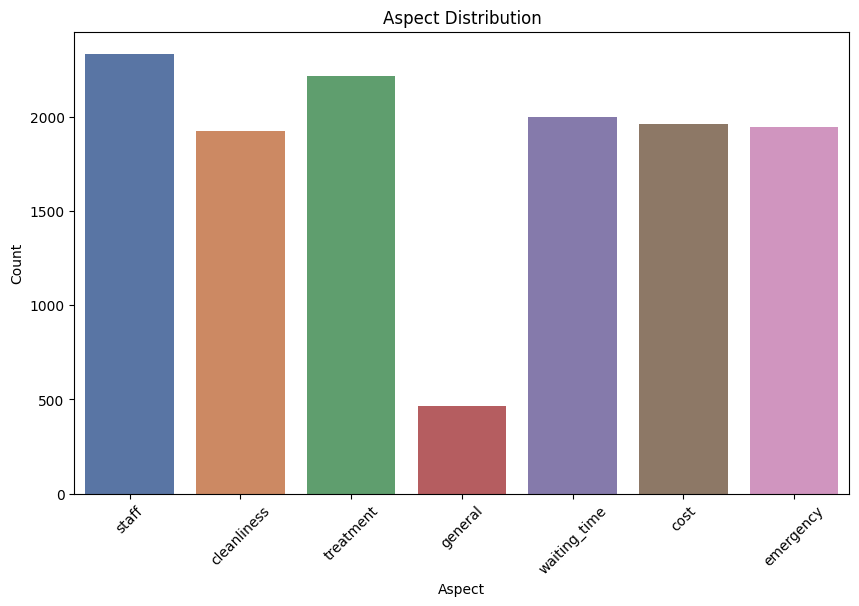

In [ ]:
#plot aspect distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Aspect', data=df, palette='deep')
plt.title('Aspect Distribution')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

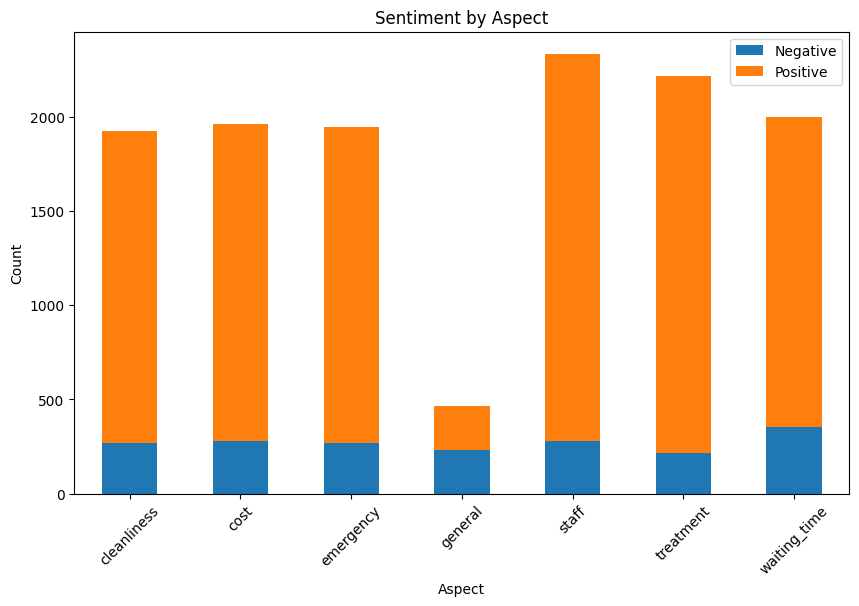

In [ ]:
# aspect wise sentiment distribution
pivot_df = df.groupby(['Aspect', 'Sentiment']).size().unstack(fill_value=0)
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.legend(['Negative', 'Positive'])
plt.xticks(rotation=45)
plt.show()

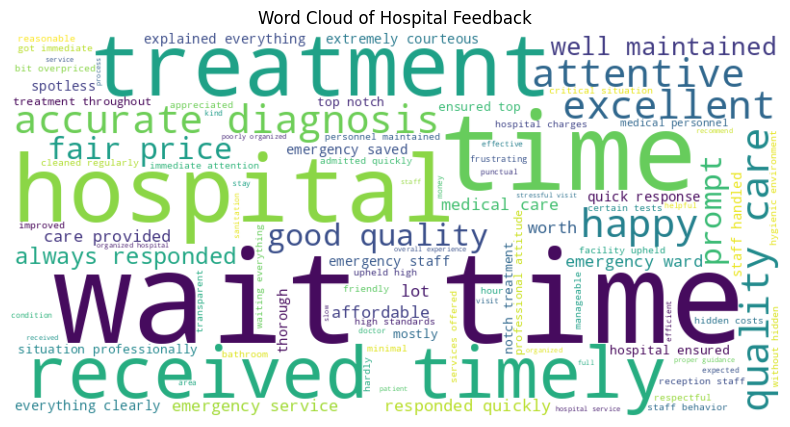

In [ ]:
# Combine cleaned feedback into a single string
feedback_text = ' '.join(df['cleaned_feedback'].dropna())

# display word cloud of feedback
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(feedback_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Hospital Feedback')
plt.show()

In [ ]:
# label encoding of aspect (target var)

aspect_encoder = LabelEncoder()
sentiment_encoder = LabelEncoder()

df['aspect_encoded'] = aspect_encoder.fit_transform(df['Aspect'])

In [ ]:
# saving the encoded aspect

aspect_mapping = {str(k): int(v) for k, v in zip(aspect_encoder.classes_, aspect_encoder.transform(aspect_encoder.classes_))}
with open('/content/drive/MyDrive/hospital_sentiment_project/aspect_mapping.json', 'w') as f:
    json.dump(aspect_mapping, f)

In [ ]:
df.head()

,Feedback,Aspect,Sentiment,cleaned_feedback,aspect_encoded
0,Good and clean hospital. There is great team o...,staff,1,good and clean hospital there is great team of...,4
1,Good and clean hospital. There is great team o...,cleanliness,1,good and clean hospital there is great team of...,0
2,Good and clean hospital. There is great team o...,treatment,1,good and clean hospital there is great team of...,5
3,Had a really bad experience during discharge. ...,staff,0,had a really bad experience during discharge t...,4
4,I have visited to take my second dose and Proc...,staff,1,i have visited to take my second dose and proc...,4


# Splitting the dataset

In [ ]:
X = df['cleaned_feedback']
y_sentiment = df['Sentiment']
y_aspect = df['aspect_encoded']

stratify_labels = (y_sentiment.astype(str) + "_" + y_aspect.astype(str))

X_train, X_test, y_sentiment_train, y_sentiment_test, y_aspect_train, y_aspect_test = train_test_split(X, y_sentiment, y_aspect, test_size=0.2, stratify=stratify_labels, random_state=42)

train_df = df.iloc[X_train.index].copy()
train_df['Sentiment'] = y_sentiment_train
train_df['aspect_encoded'] = y_aspect_train
test_df = df.iloc[X_test.index].copy()
test_df['Sentiment'] = y_sentiment_test
test_df['aspect_encoded'] = y_aspect_test

# Tokenize the data for BERT training

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize train data
train_encodings = tokenizer(
     train_df['cleaned_feedback'].tolist(),
     padding='max_length',
     max_length=128,
     truncation=True,
     return_tensors='pt'
    )
# tokenize test data
test_encodings = tokenizer(
    test_df['cleaned_feedback'].tolist(),
    padding='max_length',
    max_length=128,
    truncation=True,
    return_tensors='pt'
   )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# enable accurate CUDA error messages
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# dataset definition
class MultiTaskDataset(Dataset):
    def __init__(self, encodings, sentiments, aspects):
        self.encodings = encodings
        self.sentiments = sentiments
        self.aspects = aspects

    def __len__(self):
        return len(self.sentiments)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['sentiment'] = torch.tensor(self.sentiments[idx], dtype=torch.long)
        item['aspect'] = torch.tensor(self.aspects[idx], dtype=torch.long)
        return item

# create datasets
train_dataset = MultiTaskDataset(train_encodings, y_sentiment_train.values, y_aspect_train.values)
test_dataset = MultiTaskDataset(test_encodings, y_sentiment_test.values, y_aspect_test.values)

In [ ]:
train_dataset = MultiTaskDataset(train_encodings, y_sentiment_train.values, y_aspect_train.values)
test_dataset = MultiTaskDataset(test_encodings, y_sentiment_test.values, y_aspect_test.values)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# creating model training class
class MultiTaskBert(nn.Module):
    def __init__(self):
        super(MultiTaskBert, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.sentiment_dropout = nn.Dropout(0.1)
        self.sentiment_classifier = nn.Linear(768, 2)
        self.aspect_dropout = nn.Dropout(0.1)
        self.aspect_classifier = nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        sentiment_logits = self.sentiment_classifier(self.sentiment_dropout(pooled))
        aspect_logits = self.aspect_classifier(self.aspect_dropout(pooled))
        return sentiment_logits, aspect_logits

model = MultiTaskBert().to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# class imbalance handling
sentiment_counts = np.bincount(y_sentiment_train)
weight_0 = len(y_sentiment_train) / (2.0 * sentiment_counts[0])
weight_1 = len(y_sentiment_train) / (2.0 * sentiment_counts[1])
sentiment_weights = torch.tensor([weight_0, weight_1], dtype=torch.float).to(device)

# losses
sentiment_criterion = nn.CrossEntropyLoss(weight=sentiment_weights)
aspect_criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training Model

In [ ]:
from tqdm import tqdm

epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, leave=True, desc=f"Epoch {epoch+1}")

    for batch in loop:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiment_labels = batch['sentiment'].to(device)
        aspect_labels = batch['aspect'].to(device)

        sentiment_logits, aspect_logits = model(input_ids, attention_mask)

        sentiment_loss = sentiment_criterion(sentiment_logits, sentiment_labels)
        aspect_loss = aspect_criterion(aspect_logits, aspect_labels)

        loss = sentiment_loss + aspect_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"\n✅ Epoch {epoch+1} Completed | Average Loss: {avg_loss:.4f}\n")

print("🎉 Training Finished!")

Epoch 1: 100%|██████████| 643/643 [04:17<00:00,  2.49it/s, loss=1.39]



✅ Epoch 1 Completed | Average Loss: 1.7100



Epoch 2: 100%|██████████| 643/643 [03:53<00:00,  2.76it/s, loss=1.16]



✅ Epoch 2 Completed | Average Loss: 1.3466



Epoch 3: 100%|██████████| 643/643 [03:53<00:00,  2.75it/s, loss=1.54]


✅ Epoch 3 Completed | Average Loss: 1.2573

🎉 Training Finished!


# Saving the model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/hospital_sentiment_project/multitask_bert_model.pth')

# Model Evaluation

In [35]:
from sklearn.metrics import accuracy_score
import torch

# set model to evaluation mode
model.eval()

# evaluation function for overall performance
def evaluate_overall(model, test_loader, device):
    all_sentiment_preds = []
    all_sentiment_labels = []
    all_aspect_preds = []
    all_aspect_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiment_labels = batch['sentiment'].to(device)
            aspect_labels = batch['aspect'].to(device)

            sentiment_logits, aspect_logits = model(input_ids, attention_mask)
            sentiment_preds = torch.argmax(sentiment_logits, dim=1)
            aspect_preds = torch.argmax(aspect_logits, dim=1)

            all_sentiment_preds.extend(sentiment_preds.cpu().numpy())
            all_sentiment_labels.extend(sentiment_labels.cpu().numpy())
            all_aspect_preds.extend(aspect_preds.cpu().numpy())
            all_aspect_labels.extend(aspect_labels.cpu().numpy())

    sentiment_acc = accuracy_score(all_sentiment_labels, all_sentiment_preds)
    aspect_acc = accuracy_score(all_aspect_labels, all_aspect_preds)


    print(f"Sentiment Accuracy: {sentiment__acc:.2f}")
    print(f"Sentiment Accuracy: {aspect__acc:.2f}")

# run evaluation
evaluate_overall(model, test_loader, device)

Sentiment Accuracy: 88.39
Sentiment Accuracy: 81.76


# Prediction Function

In [33]:

# load tokenizer and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/hospital_sentiment_project/bert_tokenizer')
model = MultiTaskBert()
model.load_state_dict(torch.load('/content/drive/MyDrive/hospital_sentiment_project/multitask_bert_model.pth'))
model.to(device)
model.eval()

# prediction function
def predict_custom_input(text):
    encodings = tokenizer(text, padding='max_length', max_length=128, truncation=True, return_tensors='pt')
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    # get predictions
    with torch.no_grad():
        sentiment_logits, aspect_logits = model(input_ids, attention_mask)
        sentiment_pred = torch.argmax(sentiment_logits, dim=1).item()
        aspect_pred = torch.argmax(aspect_logits, dim=1).item()

    # map predictions to labels
    sentiment_map = {0: "Negative", 1: "Positive"}
    aspect_map = {0: "cleanliness", 1: "cost", 2: "emergency", 3: "general", 4: "staff", 5: "treatment", 6: "waiting_time"}

    return sentiment_map[sentiment_pred], aspect_map[aspect_pred]

# test with custom input
custom_input = "Average service and some staffs' behaviour is very bad specially nurses. "
sentiment, aspect = predict_custom_input(custom_input)
print(f"Custom Input: {custom_input}")
print(f"Predicted Sentiment: {sentiment}")
print(f"Predicted Aspect: {aspect}")

Custom Input: Average service and some staffs' behaviour is very bad specially nurses. 
Predicted Sentiment: Negative
Predicted Aspect: staff
